<a href="https://colab.research.google.com/github/almeidava93/others/blob/main/pred_missed_appointments_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para o modelo de pacientes que já foram atendidos antes,
 qual o número máximo de variáveis para testar?5
['pat_missing_chance', 'is_received', 'Patient → score', 'Speciality → name', 'Patient → is_first_appointment']
[0.9733151443477104, 0.9738940222931762, 0.9742240762178924, 0.9742240762178924, 0.9742240762178924]


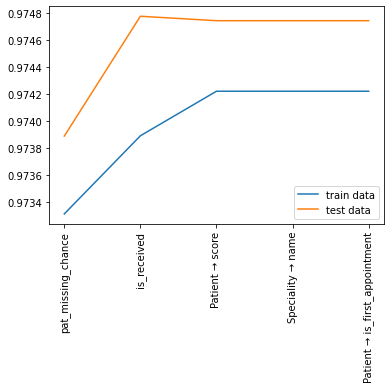

Para o modelo de pacientes que NÃO foram atendidos antes,
 qual o número máximo de variáveis para testar?5
['pat_missing_chance', 'n_of_updates', 'sch_to_app_days', 'is_confirmed', 'days_since_pat_creation']
[0.9933770161290323, 0.9949479166666667, 0.9951696908602151, 0.9955191532258064, 0.9957073252688172]


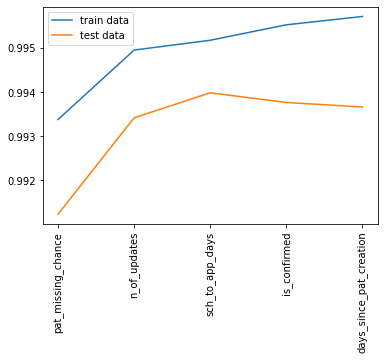

In [ ]:
'''
OBJETIVOS
- Elaborar modelo capaz de prever os paciente que irão faltar à consulta agendada
- Elaborar dois modelos: 
    um para pacientes com atendimentos prévios, 
    um para pacientes sem atendimentos prévios.
'''

#Importando pacotes relevantes
import pandas as pd
import numpy as np

from sklearn import preprocessing



#Importando os dados de interesse
data = '/content/drive/MyDrive/Colab Notebooks/Dados/appointments (21.05.2021 - Todas as clínicas - últimos 120 dias).csv'

basetable = pd.read_csv(data)



#Separando as colunas de interesse
colunas_de_interesse = ['activity_log', 'created_at', 'date', 'deleted_at', 'end_time',
       'interval', 'is_extended', 'patient_id', 'professional_id',
       'start_time', 'status', 'type', 'updated_at', 'waiting_time',
       'Professional → biological_sex', 'Professional → birth_date', 'Patient → biological_sex',
       'Patient → birth_date', 'Patient → created_at',
       'Patient → health_maintenance_organization_id',
       'Patient → is_first_appointment', 'Patient → is_foreign',
       'Patient → is_special_needs', 'Patient → marital_status', 'Patient → score', 'Patient → last_appointment_date',
       'Speciality → name', 'CareTeam → name', 'CareTeam → score',
       'Clinic → name']

basetable = basetable[colunas_de_interesse]



#AJUSTANDO O TIPO DE DADO EM CADA COLUNA
#Convertendo colunas com datas e tempo para datetime object
def datetime_correct(str):
  '''Essa função transforma a string das colunas que tem informação de data e hora
  e transforma numa string que pode ser convertida depois para datetime object.
  Não deu para fazer essa transformação de uma vez, porque o formato da string
  que vem no .csv varia mesmo dentro da mesma coluna.
  '''
  str = str.replace('T',' ')
  return str[0:19]

datetime_variables = ['created_at','updated_at','date', 'Professional → birth_date',
                      'Patient → birth_date','Patient → created_at','Patient → last_appointment_date']
time_variables = ['end_time','start_time']

for v in datetime_variables: 
  basetable[v] = basetable.apply(lambda row: datetime_correct(str(row[v])), axis=1)
  basetable[v] = pd.to_datetime(basetable[v], format="%Y-%m-%d %H:%M:%S", errors = 'coerce')

for v in time_variables:
  basetable[v] = pd.to_datetime(basetable[v], format="%H:%M:%S")



#Criando variáveis de interesse
#definindo função que checa se uma string contém uma substring e devolve True ou False.
#serve para aproveitar os dados da coluna 'activity_log'
def str_contain(str,substring):
  if substring in str:
    return True
  else:
    return False

#definindo função que calcula a idade a partir de uma data
from datetime import date
def age(born):
    today = date.today()
    return today.year - born.year - ((today.month,today.day) < (born.month,born.day))

#definindo função que conta repetições de uma substring
def count_str(string, substring):
    return string.count(substring)


#is_confirmed: a consulta do paciente foi confirmada ou não?
basetable['is_confirmed'] = basetable.apply(lambda row: str_contain(row['activity_log'],'confirmed'), axis = 1)

#is_received: o paciente foi recepcionado ou não?
basetable['is_received'] = basetable.apply(lambda row: str_contain(row['activity_log'],'received'), axis = 1)

#n_of_updates: número de vezes que o agendamento recebeu atualizações
basetable['n_of_updates'] = basetable.apply(lambda row: count_str(row['activity_log'],'status'), axis = 1)

#is_missed: o paciente faltou. Variável que queremos prever
basetable['target'] = basetable.apply(lambda row: str_contain(row['status'],'missed'), axis = 1)



#pat_age e prof_age: idade do paciente e idade do profissional
basetable['pat_age'] = basetable.apply(lambda row: age(row['Patient → birth_date']), axis = 1)
basetable['prof_age'] = basetable.apply(lambda row: age(row['Professional → birth_date']), axis = 1)

#sch_to_app_days: número de dias entre o dia do agendamento e o dia da consulta
basetable['sch_to_app_days'] = (basetable['date'] - basetable['created_at']).dt.days

#days_since_last_app: número de dias entre a última consulta e o dia da consulta
basetable['days_since_last_app'] = (basetable['date'] - basetable['Patient → last_appointment_date']).dt.days

#days_since_pat_creation: número de dias que se passaram desde o cadastro do paciente
basetable['days_since_pat_creation'] = (basetable['date'] - basetable['Patient → created_at']).dt.days

#days_since_last_update: número de dias entre a última atualização no agendamento e o dia da consulta
basetable['days_since_last_update'] = (basetable['date'] - basetable['updated_at']).dt.days

#app_weekday: dia da semana em que a consulta vai ocorrer
basetable['app_weekday'] = basetable['date'].dt.weekday

#app_hour: hora do dia em que está marcada a consulta
basetable['app_hour'] = basetable['date'].dt.hour

#pat_total_apps_number: número de agendamentos daquele paciente no período considerado
all_ocurrences = basetable['patient_id'].value_counts()

def count_pat_app(patient_id):
  return all_ocurrences.get(patient_id)

basetable['pat_total_apps_number'] = basetable['patient_id'].apply(lambda row: count_pat_app(row))

#pat_missed_apps_number: número de consultas que o paciente faltou no período
pat_apps = basetable[['patient_id','target']].value_counts()
basetable['pat_missed_apps_number'] = basetable['patient_id'].apply(lambda row: pat_apps.get(row).get(True))

#pat_missing_chance: número de faltas dividido pelo número de consultas que o paciente teve no período
basetable['pat_missing_chance'] = basetable['pat_missed_apps_number']/basetable['pat_total_apps_number']

#has_past_app: paciente tem atendimento passado
basetable['has_past_app'] = basetable['Patient → last_appointment_date'].notnull()

#has_waiting_time: paciente tem tempo de espera
basetable['has_waiting_time'] = basetable['waiting_time'].notnull()



#Convertendo colunas com variáveis categóricas
categoric_v = ['Patient → biological_sex','Patient → health_maintenance_organization_id',
               'Professional → biological_sex','interval', 'is_extended', 'patient_id', 
               'professional_id', 'status', 'type','Speciality → name', 'CareTeam → name', 
               'Clinic → name','Patient → marital_status']

#Criar categoria "undefined" para preencher dados vazios em colunas de variáveis categóricas
for v in categoric_v:
  basetable[v].fillna("Undefined", inplace=True)

category_dict = {}
for v in categoric_v:
  #iniciar o objeto que faz a conversão de categorias para integers
  le = preprocessing.LabelEncoder()
  #alimentar o objeto com os dados da coluna da variável categórica na forma de uma lista
  le.fit(list(basetable[v]))
  #printar as categorias únicas identificadas para a variável em questão na forma de uma lista
  a = list((le.classes_))
  #transformar os dados da coluna nos integers correspondentes gerados
  basetable[v] = le.transform(basetable[v])
  b = list(le.transform(le.classes_))
  #guardar em um dicionário os dados para análise depois
  category_dict[v] = [a,b]
#print(category_dict)



#SELECIONANDO VARIÁVEIS DE INTERESSE PARA O MODELO
variables = ['interval','is_extended','patient_id','professional_id',
             'type','waiting_time','Professional → biological_sex','Patient → biological_sex',
             'Patient → health_maintenance_organization_id','Patient → is_first_appointment',
             'Patient → is_foreign','Patient → is_special_needs','Patient → marital_status',
             'Patient → score','Speciality → name','CareTeam → name','CareTeam → score','Clinic → name',
             'is_confirmed', 'is_received', 'n_of_updates',
             'pat_age', 'prof_age', 'sch_to_app_days',
             'days_since_last_app', 'days_since_pat_creation',
             'app_weekday', 'app_hour',
             'pat_total_apps_number', 'pat_missed_apps_number',
             'pat_missing_chance','has_past_app']
##retirei ['status','has_waiting_time','days_since_last_update',]

target = ['target']
basetable = basetable[variables + target]



#HANDLING MISSING DATA
basetable['pat_missed_apps_number'].fillna(0,inplace=True)
basetable['pat_missing_chance'].fillna(0,inplace=True)
basetable['CareTeam → score'].fillna(basetable['CareTeam → score'].mean(),inplace=True)
basetable['Patient → score'].fillna(basetable['Patient → score'].mean(),inplace=True)
basetable['waiting_time'].fillna(basetable['waiting_time'].mean(),inplace=True)
basetable.dropna(subset=['pat_age'],inplace=True)



#SEPARANDO OS DADOS
#has_last_app: True or False
basetable_first = basetable[(basetable['has_past_app']==False)]
basetable = basetable[(basetable['has_past_app']==True)]

#Partitioning
from sklearn.model_selection import train_test_split
#cross_validation é um módulo de sklearn que contém o método train_test_split, que usamos para fazer o partitioning

x = basetable[variables]
y = basetable['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, stratify = y)
#Os primeiros dois argumentos representam variáveis preditoras e alvo.
#stratify=y representa que o alvo em y deve ser distribuído igualmente nos dados de treino e nos dados de teste.
#test_size=0.4 representa a porcentagem dos dados que devem ficar nos dados de teste. No caso, 40%. E o restante vai para o treino do modelo. 

basetable_train = pd.concat([x_train, y_train],axis=1)
basetable_test = pd.concat([x_test, y_test], axis=1)



#CONSTRUINDO O MODELO PARA PACIENTES COM ATENDIMENTOS ANTERIORES
from sklearn import linear_model
from sklearn.metrics import roc_auc_score

def auc(variables, target, basetable):
    x = basetable[variables]
    y = basetable[target]
    logreg = linear_model.LogisticRegression(max_iter=10000)
    logreg.fit(x,np.ravel(y))
    predictions = logreg.predict_proba(x)[:,1]
    auc = roc_auc_score(np.array(y), np.array(predictions))
    return auc

def next_best(current_variables, candidate_variables, target, basetable):
  best_auc = -1
  best_variable = None
  for v in candidate_variables:
    auc_v = auc(current_variables + [v], target, basetable)
    if auc_v >= best_auc:
      best_auc = auc_v
      best_variable = v
  return best_variable,best_auc

#current_variables é uma lista com os nomes das variáveis já selecionadas
#candidate_variables é uma lista com os nomes das variáveis candidatas

candidate_variables = variables
current_variables = []
target = ["target"]
aucs = []
max_number_variables = int(input('Para o modelo de pacientes que já foram atendidos antes,\n qual o número máximo de variáveis para testar?'))
number_iterations = min(max_number_variables, len(candidate_variables))

for i in range(0, number_iterations):
  next_var,next_auc = next_best(current_variables, candidate_variables, target, basetable_train)
  current_variables = current_variables + [next_var]
  aucs = aucs + [next_auc]
  candidate_variables.remove(next_var)

print(current_variables)
print(aucs)



#Testando modelo treino em dados teste
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
def auc_train_test(variables, target, train, test):
    X_train = train[variables]
    X_test = test[variables]
    Y_train = train[target]
    Y_test = test[target]
    logreg = linear_model.LogisticRegression(max_iter=7000)
    
    # Fit the model on train data
    logreg.fit(X_train, np.ravel(Y_train))
    
    # Calculate the predictions both on train and test data
    predictions_train = logreg.predict_proba(X_train)[:,1]
    predictions_test = logreg.predict_proba(X_test)[:,1]
    
    # Calculate the AUC both on train and test data
    auc_train = roc_auc_score(Y_train, predictions_train)
    auc_test = roc_auc_score(Y_test,predictions_test)
    return(auc_train, auc_test)



auc_train, auc_test = auc_train_test(current_variables, target, basetable_train, basetable_test)
#variables é a lista das variáveis preditoras utilizadas



# Keep track of train and test AUC values
auc_values_train = [] #valores de AUC no treino de cada iteração
auc_values_test = [] #valores de AUC no treino de cada iteração
variables_evaluate = [] #lista de variáveis analisadas em cada iteração

# Iterate over the variables in variables
for v in current_variables:
  
    # Add the variable
    variables_evaluate.append(v)
    
    # Calculate the train and test AUC of this set of variables
    auc_train, auc_test = auc_train_test(variables_evaluate, ["target"], basetable_train, basetable_test)
    
    # Append the values to the lists
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)


# Make plot of the AUC values
import matplotlib.pyplot as plt
import numpy as np

x = np.array(range(0,len(auc_values_train)))
y_train = np.array(auc_values_train)
y_test = np.array(auc_values_test)
plt.xticks(x, current_variables, rotation = 90)
plt.plot(x,y_train,label='train data')
plt.plot(x,y_test, label='test data')
plt.legend(loc='best')
#plt.ylim((0.96, 0.98))
plt.show()




#CONSTRUINDO O MODELO PARA PACIENTES SEM ATENDIMENTOS ANTERIORES
basetable_first.dropna(axis=1, inplace=True)
#print(basetable_first.isnull().sum())

variables = ['interval','is_extended','patient_id','professional_id',
             'type','waiting_time','Professional → biological_sex','Patient → biological_sex',
             'Patient → health_maintenance_organization_id','Patient → is_first_appointment',
             'Patient → is_foreign','Patient → is_special_needs','Patient → marital_status',
             'Patient → score','Speciality → name','CareTeam → name','CareTeam → score','Clinic → name',
             'is_confirmed', 'is_received', 'n_of_updates',
             'pat_age', 'prof_age', 'sch_to_app_days',
             'days_since_last_app', 'days_since_pat_creation',
             'app_weekday', 'app_hour',
             'pat_missing_chance','pat_total_apps_number', 'pat_missed_apps_number',
             'has_past_app']
variables.remove('days_since_last_app')

#Partitioning
from sklearn.model_selection import train_test_split

#cross_validation é um módulo de sklearn que contém o método train_test_split, que usamos para fazer o partitioning

x = basetable_first[variables]
y = basetable_first['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, stratify = y)
#Os primeiros dois argumentos representam variáveis preditoras e alvo.
#stratify=y representa que o alvo em y deve ser distribuído igualmente nos dados de treino e nos dados de teste.
#test_size=0.4 representa a porcentagem dos dados que devem ficar nos dados de teste. No caso, 40%. E o restante vai para o treino do modelo. 

basetable_train = pd.concat([x_train, y_train],axis=1)
basetable_test = pd.concat([x_test, y_test], axis=1)



from sklearn import linear_model
from sklearn.metrics import roc_auc_score

def auc(variables, target, basetable):
    x = basetable[variables]
    y = basetable[target]
    logreg = linear_model.LogisticRegression(max_iter=7000)
    logreg.fit(x,np.ravel(y))
    predictions = logreg.predict_proba(x)[:,1]
    auc = roc_auc_score(np.array(y), np.array(predictions))
    return auc

def next_best(current_variables, candidate_variables, target, basetable):
  best_auc = -1
  best_variable = None
  for v in candidate_variables:
    auc_v = auc(current_variables + [v], target, basetable)
    if auc_v >= best_auc:
      best_auc = auc_v
      best_variable = v
  return best_variable,best_auc

#current_variables é uma lista com os nomes das variáveis já selecionadas
#candidate_variables é uma lista com os nomes das variáveis candidatas

candidate_variables = variables
current_variables = []
target = ["target"]
aucs = []
max_number_variables = int(input('Para o modelo de pacientes que NÃO foram atendidos antes,\n qual o número máximo de variáveis para testar?'))
number_iterations = min(max_number_variables, len(candidate_variables))

for i in range(0, number_iterations):
  next_var,next_auc = next_best(current_variables, candidate_variables, target, basetable_train)
  current_variables = current_variables + [next_var]
  aucs = aucs + [next_auc]
  candidate_variables.remove(next_var)

print(current_variables)
print(aucs)


from sklearn import linear_model
from sklearn.metrics import roc_auc_score
def auc_train_test(variables, target, train, test):
    X_train = train[variables]
    X_test = test[variables]
    Y_train = train[target]
    Y_test = test[target]
    logreg = linear_model.LogisticRegression(max_iter=10000)
    
    # Fit the model on train data
    logreg.fit(X_train, np.ravel(Y_train))
    
    # Calculate the predictions both on train and test data
    predictions_train = logreg.predict_proba(X_train)[:,1]
    predictions_test = logreg.predict_proba(X_test)[:,1]
    
    # Calculate the AUC both on train and test data
    auc_train = roc_auc_score(Y_train, predictions_train)
    auc_test = roc_auc_score(Y_test,predictions_test)
    return(auc_train, auc_test)



auc_train, auc_test = auc_train_test(current_variables, target, basetable_train, basetable_test)
#variables é a lista das variáveis preditoras utilizadas



# Keep track of train and test AUC values
auc_values_train = [] #valores de AUC no treino de cada iteração
auc_values_test = [] #valores de AUC no treino de cada iteração
variables_evaluate = [] #lista de variáveis analisadas em cada iteração

# Iterate over the variables in variables
for v in current_variables:
  
    # Add the variable
    variables_evaluate.append(v)
    
    # Calculate the train and test AUC of this set of variables
    auc_train, auc_test = auc_train_test(variables_evaluate, ["target"], basetable_train, basetable_test)
    
    # Append the values to the lists
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)



# Make plot of the AUC values
import matplotlib.pyplot as plt
import numpy as np

x = np.array(range(0,len(auc_values_train)))
y_train = np.array(auc_values_train)
y_test = np.array(auc_values_test)
plt.xticks(x, current_variables, rotation = 90)
plt.plot(x,y_train,label='train data')
plt.plot(x,y_test, label='test data')
plt.legend(loc='best')
#plt.ylim((0.96, 0.98))
plt.show()